# Initialisation

In [15]:
from google.colab import drive
import os 
import sys

drive.mount('/content/drive') 
os.chdir('/content/drive/My Drive/Colab Notebooks/P7_Réalisez des indexations automatiques d’images')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import tarfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import pickle
from PIL import Image, ImageOps
from collections import Counter
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split, GridSearchCV

from skimage.transform import resize
%matplotlib inline
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input, VGG16, decode_predictions
from keras.models import Model

# Constantes et fonctions

In [17]:
WIDTH = 224
HEIGHT = 224

# Chargement des images

In [18]:
dict_dogs = dict()
tailles = [] 
modes = [] 
temp = []
#dogs_df = pd.DataFrame(columns=['race', 'img_mtx'])

with tarfile.open('images.tar', 'r:tar') as tarFile:
    #tarInfo = tarFile.next()
    for d in tarFile.getmembers():
        if d.isfile():
            last_slash = d.name.rfind('/')
            race = d.name[d.name.rfind('/', 1, last_slash)+1:last_slash]
            race = race[race.find('-')+1:]
            img_idx = d.name[last_slash+1:]

            file = tarFile.extractfile(d)
            img = Image.open(file)
            tailles.append(img.size)
            modes.append(img.mode)
            
            if img.mode != 'RGB':
                img = img.convert('RGB')

            # Dimensionnement des images 
            img = img.resize((WIDTH, HEIGHT))

            temp.append([race, img])

            #if race in dict_dogs.keys():
            #    dict_dogs[race].append(img_array)
            #else:
            #    dict_dogs[race] = [img_array]

dogs_df = pd.DataFrame(temp, columns=['race', 'img'])

#print('Top20 des tailles de photos\n', Counter(tailles).most_common(20), '\nQualité', Counter(modes).most_common())

print('\nTaille du df :', dogs_df.info())
dogs_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20580 entries, 0 to 20579
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   race    20580 non-null  object
 1   img     20580 non-null  object
dtypes: object(2)
memory usage: 321.7+ KB

Taille du df : None


,race,img
0,Chihuahua,<PIL.Image.Image image mode=RGB size=224x224 a...
1,Chihuahua,<PIL.Image.Image image mode=RGB size=224x224 a...
2,Chihuahua,<PIL.Image.Image image mode=RGB size=224x224 a...
3,Chihuahua,<PIL.Image.Image image mode=RGB size=224x224 a...
4,Chihuahua,<PIL.Image.Image image mode=RGB size=224x224 a...


## Galerie (1 image par espèce)

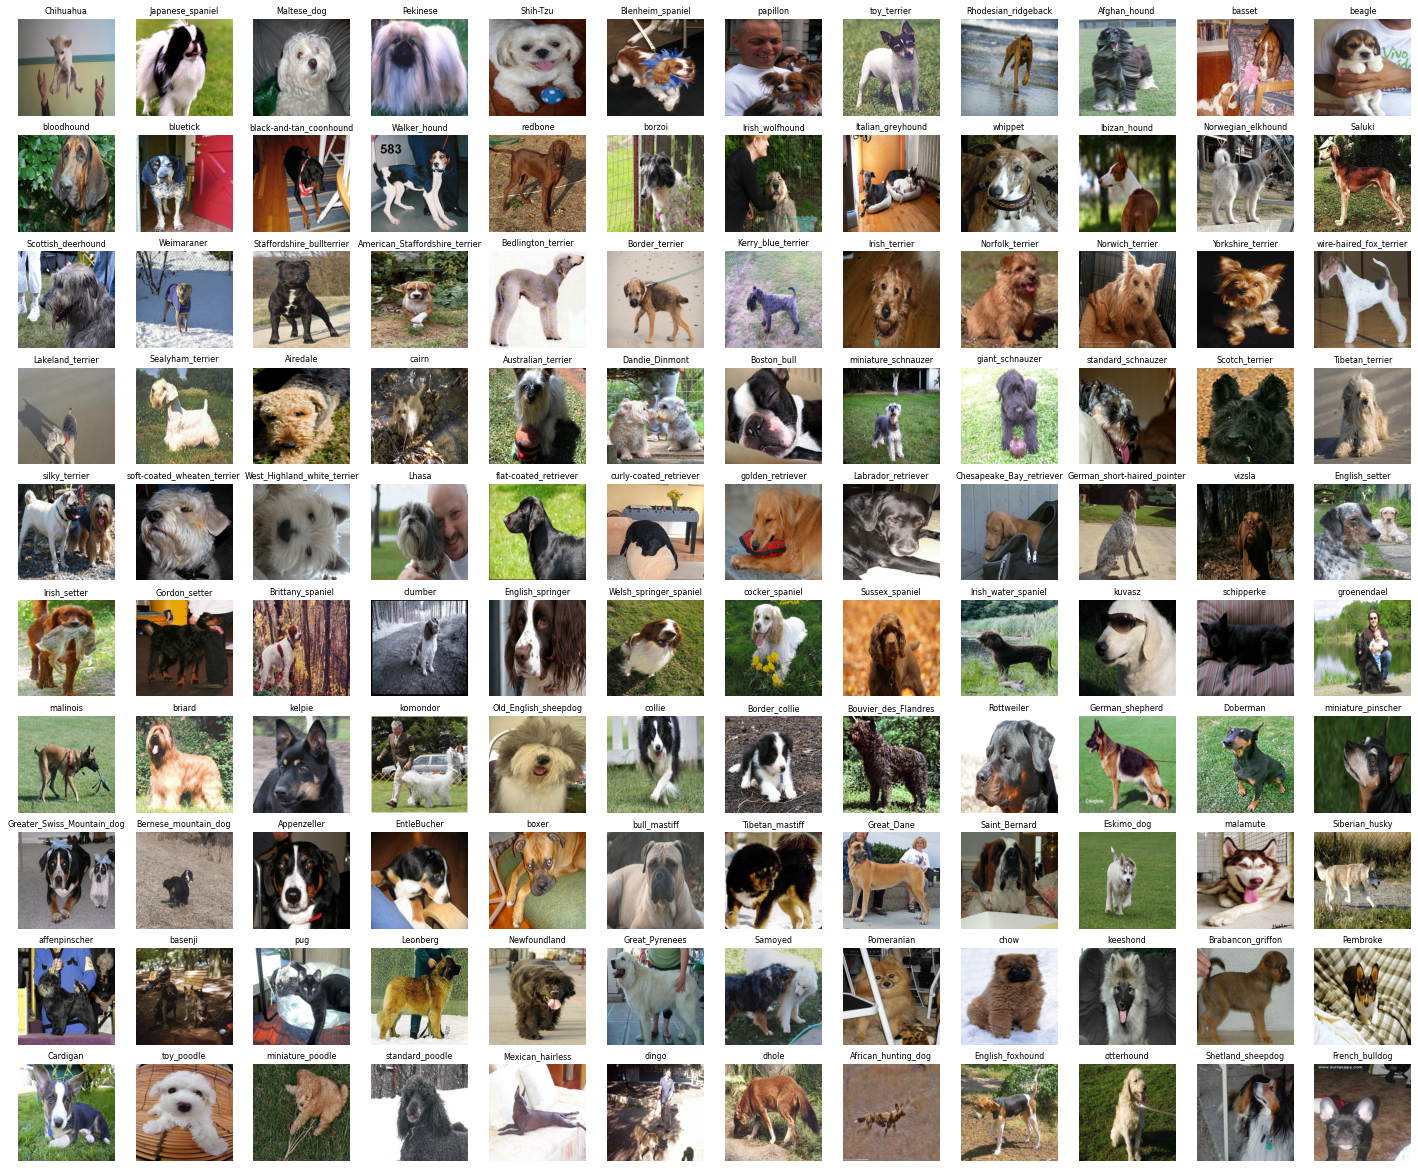

In [19]:
breeds = dogs_df.race.unique()
fig = plt.figure(figsize=(25, 21))
cpt = 0 

for n in breeds: 
    cpt += 1 
    #plt.figure(figsize=(2, 2))
    plt.subplot(10, 12, cpt)
    plt.title(n, fontsize=8)
    plt.axis('off')
    plt.imshow(dogs_df[dogs_df.race == n].img.iloc[0])

## Tailles initiales des photos

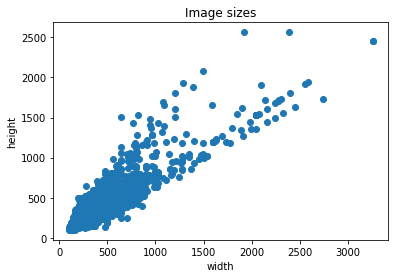

In [20]:
shapes = np.asarray(tailles)
plt.plot(shapes[:, 0], shapes[:, 1], "o")
plt.title("Image sizes")
plt.xlabel("width")
_ = plt.ylabel("height")

## Modes initiaux

In [21]:
Counter(modes).most_common()

[('RGB', 20579), ('RGBA', 1)]

## Nettoyage des images

In [35]:
for i, v in dogs_df.iterrows():

    # Correction de l'exposition
    temp = ImageOps.autocontrast(v['img'])

    # Correction du contraste
    temp = ImageOps.equalize(temp)

    dogs_df.loc[i, 'img'] = np.array(temp)

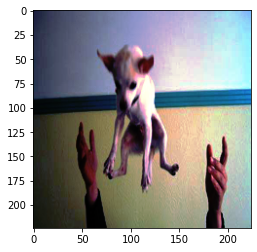

In [39]:
plt.imshow(dogs_df[dogs_df.index == 0].img.iloc[0])

# Exploration

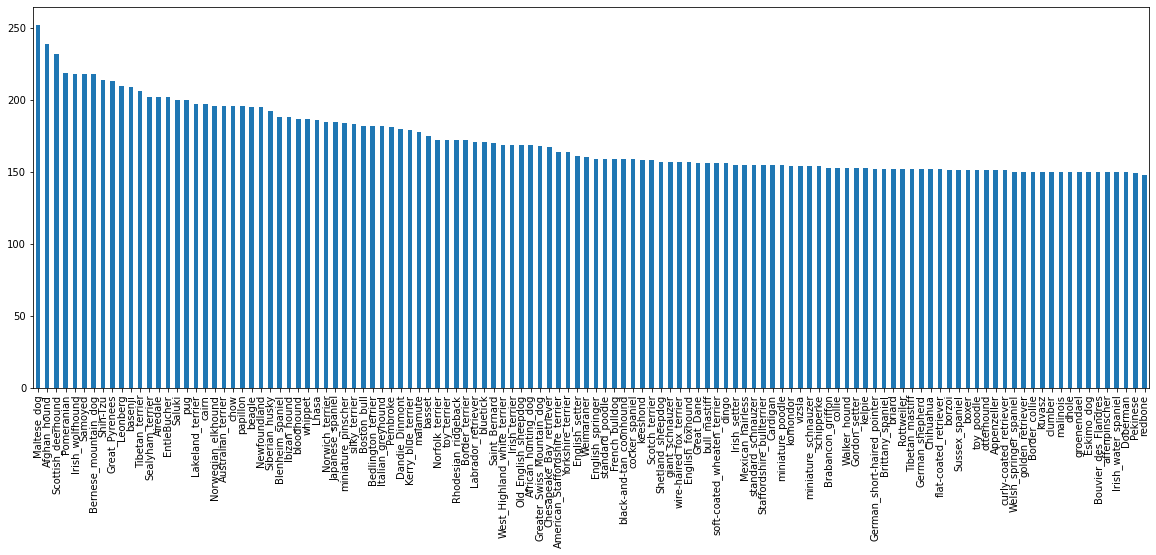

In [ ]:
fig = plt.figure(figsize=(20, 7))
dogs_df['race'].value_counts().plot.bar()

## Etiquetage des espèces de chiens

In [ ]:
race_lbl = LabelEncoder() 
dogs_df['race_lbl'] = race_lbl.fit_transform(dogs_df.race)

## Réduction au top20 des races présentes

In [ ]:
source = dogs_df[dogs_df.race.isin(dogs_df['race'].value_counts()[:40].index)][['img_mtx', 'race_lbl']].copy()
source.shape

(7994, 2)

## Séparation train/test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(source.img_mtx, source.race_lbl, test_size=0.3)
X_train.shape, X_test.shape

((5595,), (2399,))

# Approche standard

## SIFT

# CNN

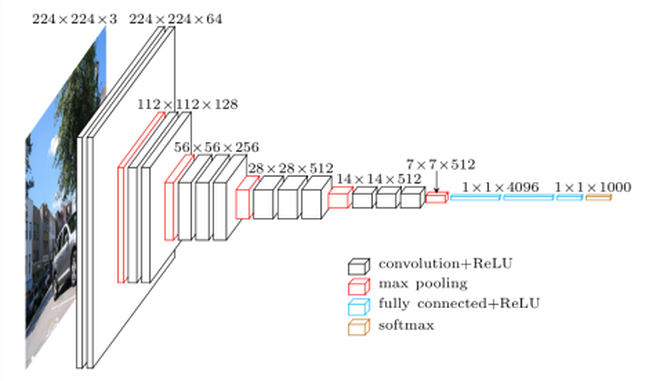

## Base line

In [ ]:
base_model = VGG16()

553467904/553467096 [==============================] - 5s 0us/step


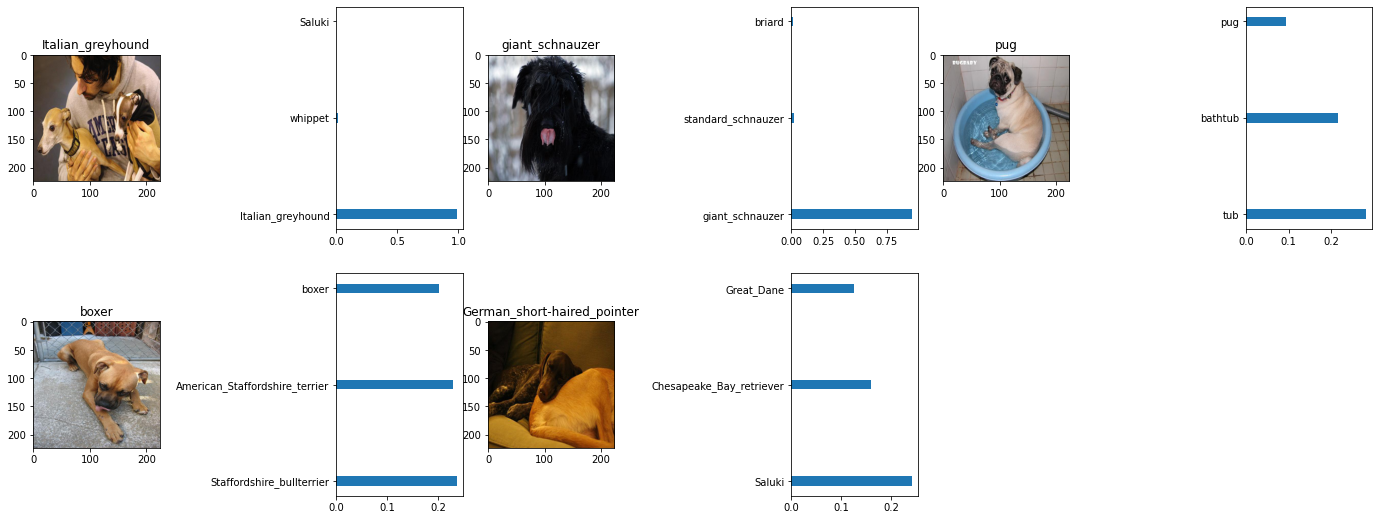

In [ ]:
temp = dogs_df.sample(5) 
fig = plt.figure(figsize=(24, 9))
plt.axis('off')
cpt = 0 

for i, v in temp.iterrows(): 
    cpt += 1 

    img = v.img_mtx
    img_vgg = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
    img_vgg = preprocess_input(img_vgg)  # Prétraiter l'image comme le veut VGG-16

    y = base_model.predict(img_vgg)  # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)
    pred = decode_predictions(y, top=3)[0]

    plt.subplot(2, 9, cpt)
    plt.imshow(img)
    plt.title(v.race)
    cpt += 2
    plt.subplot(2, 9, cpt)
    plt.barh([w[1] for w in pred], [w[2] for w in pred], height=.1)
    # Afficher les 3 classes les plus probables
    #print('Top 3 :', decode_predictions(y, top=3)[0])

## Transfer learning

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

J'entraine seulement les couches les plus hautes (fine-tunning partiel)

In [ ]:
for layer in base_model.layers[:-3]:
   layer.trainable = False

In [ ]:
base_model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [ ]:
y = base_model.predict(img)  # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)

# Afficher les 3 classes les plus probables
print('Top 3 :', decode_predictions(y, top=3)[0])

Top 3 : [('n02085782', 'Japanese_spaniel', 0.99907947), ('n02086910', 'papillon', 0.0006507259), ('n02086079', 'Pekinese', 0.00024814883)]
